# Predicting the NBA MVP with Machine Learning

<img src="https://i0.wp.com/fumblenanet.com.br/wp-content/uploads/2021/04/mvp-trophy.jpg?fit=1200%2C630&ssl=1" width="650"/>

Notebook containing the code described in **[Medium](https://medium.com/@gabriel.pastorello/predicting-the-nba-mvp-with-machine-learning-c3e5b755f42e "Medium")**.

Complete code and databases in **[GitHub](https://github.com/GabrielPastorello/NBA-Modelo-MVP "GitHub")**.

# Index

**1. [Importing packages](#Importing-packages)**

**2. [Opening and processing the data](#Opening-and-processing-the-data)**

**3. [Modeling 2021-22](#Modeling-2021-22)**

**4. [Old seasons](#Old-seasons)**

**5. [Variable Analysis - SHAP](#Variable-Analysis---SHAP)**

## Importing packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Defining the seasons and models used
seasons = ['2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07'] 
           
modelos = ['SVM','Elastic Net','Random Forest','AdaBoost','Gradient Boosting',]#'LGBM']

# Path to local folder
path_data = '/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/NBA-Modelo-MVP/Modelo MVP'

sep = r'/'

## Opening and processing the data

In [5]:
def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    avancados = pd.DataFrame()
    standings = pd.DataFrame()

    for season in seasons:
        pergame = pd.read_csv(path_data+sep+'Dados'+sep+season+' Por Jogo.csv',
                               sep=',', decimal='.')

        total = pd.read_csv(path_data+sep+'Dados'+sep+season+' Total.csv',
                            sep=',', decimal='.')
        
        avancado = pd.read_csv(path_data+sep+'Dados'+sep+season+' Avançados.csv',
                               sep=',', decimal='.')
        
        standing = pd.read_csv(path_data+sep+'Dados'+sep+season+' Standings.csv',
                               sep=',', decimal='.')
        
        
        pergame['Season'] = season
        total['Season'] = season
        avancado['Season'] = season
        standing['Season'] = season
        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        avancados = pd.concat([avancados,avancado], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)
    
    #print(avancados)
    print(per_game['Player'].value_counts()['Bam Adebayo\\adebaba01'])

    return per_game, totals, avancados, standings

In [6]:
def treat_data(per_game, totals, avancados, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    avancados = avancados.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1)
    
    cols = ['Player','Season','Pos','Age','Tm','G','GS']
    
    # Identifying the variables
    for coluna in per_game.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_PERGAME'
            per_game = per_game.rename(columns={coluna:nova_coluna})
    for coluna in totals.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_TOTAL'
            totals = totals.rename(columns={coluna:nova_coluna})
    for coluna in avancados.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_AVANCADO'
            avancados = avancados.rename(columns={coluna:nova_coluna})
    
    # Merging the bases
    data = per_game.merge(avancados, on=['Player','Season','Tm'], how='left', validate='1:1')
    data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')
    
    mvps = pd.read_csv(path_data+sep+'Dados'+sep+'MVPs.csv',sep=',', decimal='.')
    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    
    # Removing duplicate lines from traded players
    dataf = pd.DataFrame()
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)
    
    # Filtering the data
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_AVANCADO']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)
    
    # Base for the criteria:
    # Karl Malone was MVP in 98-99 with 49 games
    # Wes Unseld was MVP at 68-69 with 13.8 PPG and with 10.9 FGA
    # Steve Nash was MVP at 04-05 with 3.3 REB
    # Moses Malone was MVP at 82-83 with 1.3 AST
    # Bob Cousy was MVP at 56-57 with 37.8% FG
    # Giannis Antetokounmpo was MVP in 19-20 with 30.4 min
    # Kareem Abdul-Jabbar was the only MVP not to make the playoffs in 1976 (40-42)
    # Dave Cowens was MVP at 72-73 with a PER of 18.1
    # Never has an MVP been traded in the middle of the season that he won the award
        
    dataf = dataf.drop(['Tm','Team','Record'], axis=1)
    dataf.to_csv("FinalDataFrame-MVP.csv", index=False)
    return dataf

In [7]:
per_game, totals, avancados, standings = get_data(seasons)




5


In [8]:
data = treat_data(per_game, totals, avancados, standings, seasons)

3


In [9]:
data

,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,...,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share
0,Bam Adebayo,24,56,56,32.6,7.3,13.0,0.557,0.0,0.1,...,190,80,44,148,171,1068,4.0,0.646341,0,0.000
1,Giannis Antetokounmpo,27,67,67,32.9,10.3,18.6,0.553,1.1,3.6,...,388,72,91,219,212,2002,7.0,0.621951,3,0.595
2,Devin Booker,25,68,68,34.5,9.7,20.9,0.466,2.7,7.0,...,329,77,26,162,180,1822,1.0,0.780488,4,0.216
3,Jaylen Brown,25,66,66,33.6,8.7,18.4,0.473,2.5,7.0,...,231,70,18,178,163,1559,6.0,0.621951,0,0.000
4,Jimmy Butler,32,57,57,33.9,7.0,14.5,0.480,0.5,2.0,...,312,94,27,121,88,1219,4.0,0.646341,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,Tony Parker,24,77,77,32.5,7.4,14.2,0.520,0.2,0.5,...,420,82,6,191,137,1429,3.0,0.707317,15T,0.001
404,Chris Paul,21,64,64,36.8,6.0,13.6,0.437,0.8,2.2,...,569,118,3,161,154,1104,0.0,0.000000,0,0.000
405,Amar'e Stoudemire,24,82,78,32.8,7.4,12.9,0.575,0.0,0.0,...,84,78,110,232,295,1671,2.0,0.743902,14,0.002
406,Dwyane Wade,25,51,50,37.9,9.3,18.9,0.491,0.4,1.5,...,384,107,62,216,117,1397,11.0,0.536585,12T,0.002


In [10]:
data.columns # Variables

Index(['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_AVANCADO',
       'TS%_AVANCADO', '3PAr_AVANCADO', 'FTr_AVANCADO', 'ORB%_AVANCADO',
       'DRB%_AVANCADO', 'TRB%_AVANCADO', 'AST%_AVANCADO', 'STL%_AVANCADO',
       'BLK%_AVANCADO', 'TOV%_AVANCADO', 'USG%_AVANCADO', 'OWS_AVANCADO',
       'DWS_AVANCADO', 'WS_AVANCADO', 'WS/48_AVANCADO', 'OBPM_AVANCADO',
       'DBPM_AVANCADO', 'BPM_AVANCADO', 'VORP_AVANCADO', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 

In [11]:
data['Season'].value_counts() # Number of players in the data per season

2016-17    29
2011-12    29
2007-08    29
2006-07    29
2020-21    28
2010-11    28
2013-14    27
2009-10    27
2021-22    25
2018-19    25
2015-16    24
2012-13    24
2014-15    22
2019-20    21
2008-09    21
2017-18    20
Name: Season, dtype: int64

## Modeling 2021-22

In [12]:
# Function for metrics
def func_metricas(y_test, y_pred, metricas, modelo, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Modelo': [modelo],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metrica = pd.DataFrame(data=dict_met)
    metricas = pd.concat([metricas,metrica])
    
    return metricas

In [13]:
def func_modelos(data, seasons, modelos, n_seasons_to_test):
    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for modelo in modelos:
            # Creating instance for each model
            if modelo=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif modelo=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif modelo=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            model.fit(scaled_X_train, y_train)
            
            print("FinalModel:")
            print(model)
            print("SEP: ")
            print(sep)
            print("MODELo: ")
            print(modelo)
            pickle.dump(model,open(path_data+sep+'Modelos'+sep+modelo+'.dat','wb'))#),'wb')
            
            y_pred = model.predict(scaled_X_test)
            metricas = func_metricas(y_test, y_pred, metricas, modelo, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+modelo] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+modelo,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+modelo] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Modelos\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metricas, best_params

In [14]:
def media_metricas(metricas):
    # Averages of each of the models
    final_metricas = pd.DataFrame()
    for modelo in metricas['Modelo'].unique():
        metrica = metricas[metricas['Modelo']==modelo]
        rmse = round(metrica['RMSE'].mean(),3)
        r2 = round(metrica['R²'].mean(),3)

        dict_met = {'Modelo': [modelo],
                    'RMSE': [rmse],
                    'R²': [r2]}

        apoio = pd.DataFrame(data=dict_met)
        final_metricas = pd.concat([final_metricas,apoio], ignore_index=True)
    return final_metricas

In [15]:
final_results, metricas, best_params = func_modelos(data, seasons, modelos, 1)
final_metricas = media_metricas(metricas)
final_metricas

FinalModel:
SVR(C=0.5, degree=2, gamma='auto')
SEP: 
/
MODELo: 
SVM
FinalModel:
ElasticNet(alpha=0.01)
SEP: 
/
MODELo: 
Elastic Net
FinalModel:
RandomForestRegressor(max_features=4, n_estimators=25, oob_score=True)
SEP: 
/
MODELo: 
Random Forest
FinalModel:
AdaBoostRegressor(learning_rate=0.1, n_estimators=100)
SEP: 
/
MODELo: 
AdaBoost
FinalModel:
GradientBoostingRegressor(n_estimators=50)
SEP: 
/
MODELo: 
Gradient Boosting


,Modelo,RMSE,R²
0,SVM,0.087,0.867
1,Elastic Net,0.153,0.585
2,Random Forest,0.086,0.869
3,AdaBoost,0.124,0.727
4,Gradient Boosting,0.111,0.782


In [16]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Votes Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Votes Share']
        for modelo in modelos:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+modelo, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+modelo] = temp2['Player']
                rank['MVP Share '+modelo] = round(temp2['Predicted MVP Share '+modelo],3)
            except:
                continue

        rank['Season'] = season    
        rank_final = pd.concat([rank_final, rank], ignore_index=True)
    
    return rank_final

In [17]:
pd.options.display.max_rows = 288
rank_final = create_rank(final_results, 18)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank Elastic Net,MVP Share Elastic Net,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.806,Nikola Jokić,0.549,Nikola Jokić,0.771,Nikola Jokić,0.648,Giannis Antetokounmpo,0.612,2021-22
1,Joel Embiid,0.706,Giannis Antetokounmpo,0.706,Giannis Antetokounmpo,0.432,Giannis Antetokounmpo,0.550,Giannis Antetokounmpo,0.575,Nikola Jokić,0.571,2021-22
2,Giannis Antetokounmpo,0.595,Joel Embiid,0.536,Joel Embiid,0.354,Joel Embiid,0.434,Joel Embiid,0.274,Joel Embiid,0.387,2021-22
3,Devin Booker,0.216,Luka Dončić,0.300,Luka Dončić,0.314,LeBron James,0.213,Luka Dončić,0.231,Ja Morant,0.232,2021-22
4,Luka Dončić,0.146,LeBron James,0.149,Ja Morant,0.207,Luka Dončić,0.170,LeBron James,0.196,Luka Dončić,0.232,2021-22
5,Jayson Tatum,0.043,Devin Booker,0.148,Jayson Tatum,0.183,Devin Booker,0.121,Ja Morant,0.196,Devin Booker,0.139,2021-22
6,Ja Morant,0.010,Ja Morant,0.146,Kevin Durant,0.177,Jayson Tatum,0.111,Trae Young,0.120,LeBron James,0.130,2021-22
7,Stephen Curry,0.004,Kevin Durant,0.111,Stephen Curry,0.170,Trae Young,0.106,Kevin Durant,0.103,Kevin Durant,0.125,2021-22
8,Chris Paul,0.002,Chris Paul,0.109,Trae Young,0.147,Stephen Curry,0.087,DeMar DeRozan,0.067,Trae Young,0.120,2021-22
9,DeMar DeRozan,0.001,Jayson Tatum,0.100,Devin Booker,0.143,Ja Morant,0.079,Jayson Tatum,0.054,Chris Paul,0.066,2021-22


##  Old seasons

In [18]:
def temporadas_antigas(data, seasons, modelos, n_seasons_to_test):
    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separating training and testing bases
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for modelo in modelos:
            
            if modelo=='Elastic Net':
                continue
            
            # Opening the models already created          
            model = pickle.load(open(path_data+sep+'Modelos'+sep+modelo+'.dat', 'rb'))
                
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
            metricas = func_metricas(y_test, y_pred, metricas, modelo, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+modelo] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+modelo,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+modelo] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metricas

In [19]:
final_results, metricas = temporadas_antigas(data, seasons, modelos, 16)
final_metricas = media_metricas(metricas)
final_metricas

,Modelo,RMSE,R²
0,SVM,0.136,0.642
1,Random Forest,0.135,0.643
2,AdaBoost,0.138,0.630
3,Gradient Boosting,0.128,0.680


In [20]:
rank_final = create_rank(final_results, 1)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank SVM,MVP Share SVM,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.806,Nikola Jokić,0.776,Nikola Jokić,0.670,Giannis Antetokounmpo,0.612,2021-22
1,Nikola Jokić,0.961,Nikola Jokić,0.728,Nikola Jokić,0.652,Nikola Jokić,0.622,Nikola Jokić,0.585,2020-21
2,Giannis Antetokounmpo,0.952,Giannis Antetokounmpo,0.661,Giannis Antetokounmpo,0.584,Giannis Antetokounmpo,0.622,Giannis Antetokounmpo,0.767,2019-20
3,Giannis Antetokounmpo,0.932,Giannis Antetokounmpo,0.738,James Harden,0.656,James Harden,0.702,Giannis Antetokounmpo,0.785,2018-19
4,James Harden,0.955,James Harden,0.710,James Harden,0.600,James Harden,0.784,James Harden,0.947,2017-18
5,Russell Westbrook,0.879,LeBron James,0.519,Russell Westbrook,0.496,Kawhi Leonard,0.671,Russell Westbrook,0.595,2016-17
6,Stephen Curry,1.000,LeBron James,0.601,Stephen Curry,0.639,Stephen Curry,0.841,Stephen Curry,1.023,2015-16
7,Stephen Curry,0.922,Stephen Curry,0.489,Stephen Curry,0.654,Stephen Curry,0.661,Stephen Curry,0.616,2014-15
8,Kevin Durant,0.986,Kevin Durant,0.813,Kevin Durant,0.743,Kevin Durant,0.758,Kevin Durant,0.793,2013-14
9,LeBron James,0.998,LeBron James,0.882,LeBron James,0.777,LeBron James,0.839,LeBron James,0.902,2012-13


## Variable Analysis - SHAP

In [21]:
#OLD METHOD
'''
data_test = data[data['Season']=='2021-22']
X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)

scaler = StandardScaler()

scaled_X_test = scaler.transform(X_test)
'''
# Split your data into training and testing
data_train = data[data['Season'] != '2021-22']
data_test = data[data['Season'] == '2021-22']

# Drop unnecessary columns
X_train = data_train.drop(['MVP Votes Share', 'MVP Rank', 'Player', 'Season'], axis=1)
X_test = data_test.drop(['MVP Votes Share', 'MVP Rank', 'Player', 'Season'], axis=1)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Now transform the test data using the fitted scaler
scaled_X_test = scaler.transform(X_test)


In [22]:
svm_model = pickle.load(open(path_data+sep+'Modelos'+sep+'SVM.dat','rb'))

In [23]:
explainer = shap.Explainer(svm_model.predict, scaled_X_test)
shap_values = explainer(scaled_X_test)

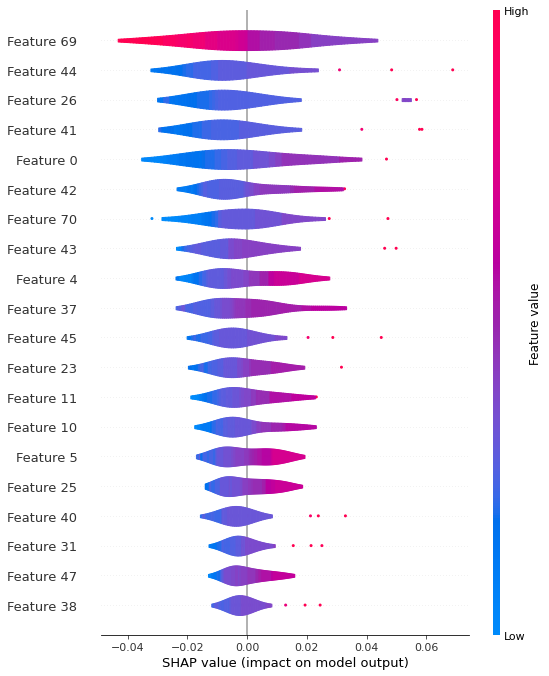

In [24]:
shap.summary_plot(shap_values, X_test, plot_type='violin') # Top 20 variables

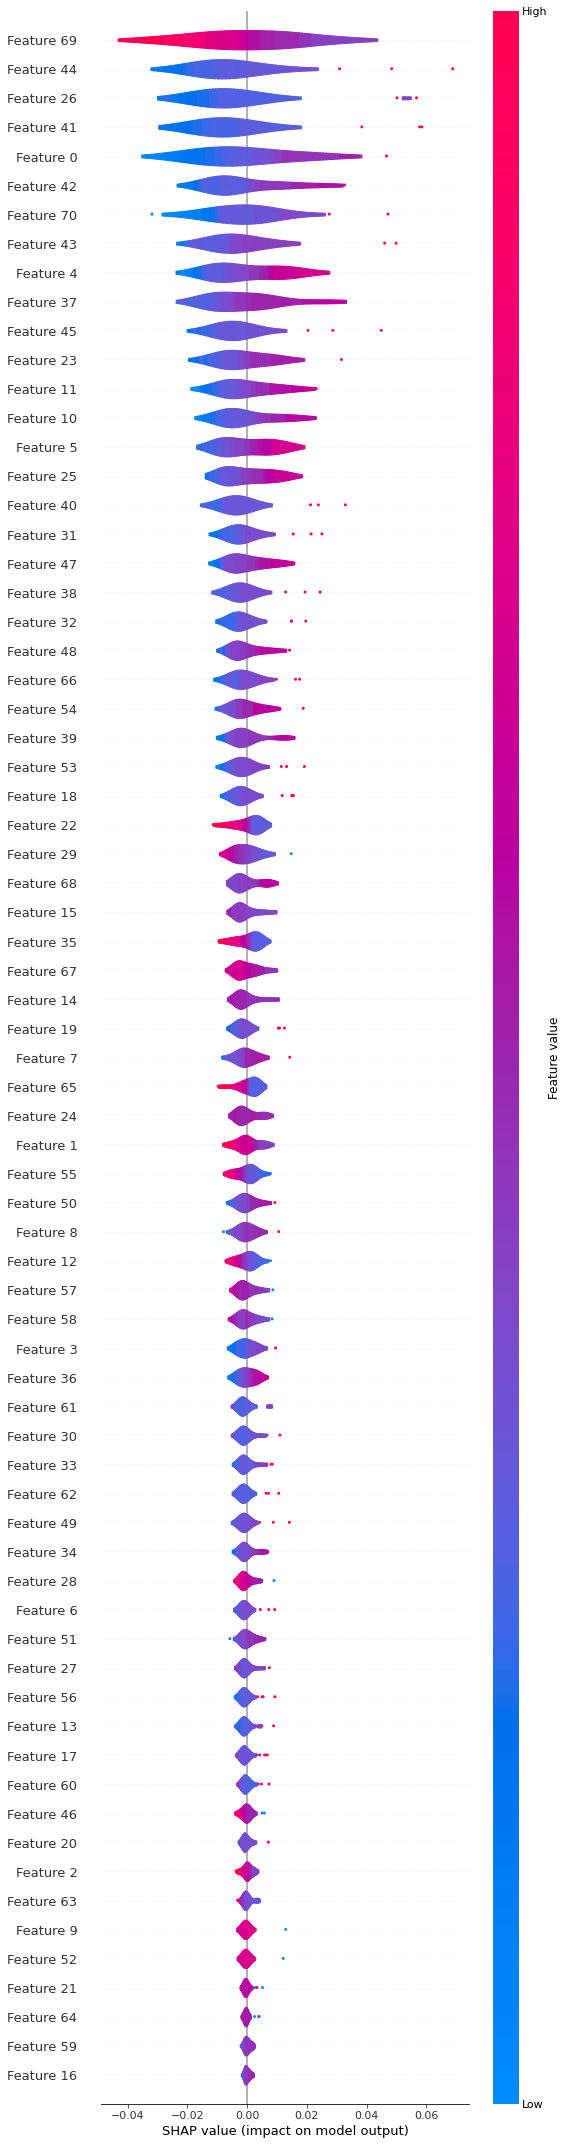

In [25]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All variables